In [1]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.float_format', '{:.2f}'.format)
fig_path = '../figures/'

In [2]:
df = pd.read_csv('../data/ultra_marathons_data_cleaned.csv')
try:
    df.drop('Unnamed: 0', axis=1, inplace=True)
except:
    pass
df['fastest_time'] = pd.to_timedelta(df['fastest_time'], errors = 'coerce')
df.head()

C:\Users\OMEN\AppData\Local\Temp\ipykernel_17740\1987717982.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/ultra_marathons_data_cleaned.csv')


,year_of_event,event_name,distance_or_length,no_of_finishers,total_distance,athlete_club,athlete_country,birth_year,gender,age_category,average_speed,athlete_id,race_metric,start_date,end_date,fastest_time
0,2018,Selva Costera (CHI),50.00,22,0.00,Tnfrc,CHI,1978,M,M35,10.286,0,km,2018-01-06,2018-01-06,0 days 04:51:39
1,2018,Selva Costera (CHI),50.00,22,0.00,Roberto Echeverría,CHI,1981,M,M35,9.501,1,km,2018-01-06,2018-01-06,0 days 05:15:45
2,2018,Selva Costera (CHI),50.00,22,0.00,Puro Trail Osorno,CHI,1987,M,M23,9.472,2,km,2018-01-06,2018-01-06,0 days 05:16:44
3,2018,Selva Costera (CHI),50.00,22,0.00,Columbia,ARG,1976,M,M40,8.976,3,km,2018-01-06,2018-01-06,0 days 05:34:13
4,2018,Selva Costera (CHI),50.00,22,0.00,Baguales Trail,CHI,1992,M,M23,8.469,4,km,2018-01-06,2018-01-06,0 days 05:54:14


In [3]:
df.isnull().sum()

year_of_event            0
event_name               0
distance_or_length    1436
no_of_finishers          0
total_distance           2
athlete_club            42
athlete_country          3
birth_year               0
gender                   7
age_category             0
average_speed          224
athlete_id               0
race_metric           1436
start_date               0
end_date                19
fastest_time           189
dtype: int64

In [4]:
# Converting all km measurements to miles

km_mask = df['race_metric'] == 'km'
df.loc[km_mask, 'distance_or_length'] = df.loc[km_mask, 'distance_or_length'] / 1.60934
df.loc[km_mask, 'race_metric'] = 'mi'

day_mask = df['race_metric'] == 'days'
df.loc[day_mask, 'distance_or_length'] = df.loc[day_mask, 'distance_or_length'] * 24
df.loc[day_mask, 'race_metric'] = 'hours'

df.head()

,year_of_event,event_name,distance_or_length,no_of_finishers,total_distance,athlete_club,athlete_country,birth_year,gender,age_category,average_speed,athlete_id,race_metric,start_date,end_date,fastest_time
0,2018,Selva Costera (CHI),31.07,22,0.00,Tnfrc,CHI,1978,M,M35,10.286,0,mi,2018-01-06,2018-01-06,0 days 04:51:39
1,2018,Selva Costera (CHI),31.07,22,0.00,Roberto Echeverría,CHI,1981,M,M35,9.501,1,mi,2018-01-06,2018-01-06,0 days 05:15:45
2,2018,Selva Costera (CHI),31.07,22,0.00,Puro Trail Osorno,CHI,1987,M,M23,9.472,2,mi,2018-01-06,2018-01-06,0 days 05:16:44
3,2018,Selva Costera (CHI),31.07,22,0.00,Columbia,ARG,1976,M,M40,8.976,3,mi,2018-01-06,2018-01-06,0 days 05:34:13
4,2018,Selva Costera (CHI),31.07,22,0.00,Baguales Trail,CHI,1992,M,M23,8.469,4,mi,2018-01-06,2018-01-06,0 days 05:54:14


In [5]:
df['race_metric'].value_counts()

race_metric
mi       6933103
hours     526656
Name: count, dtype: int64

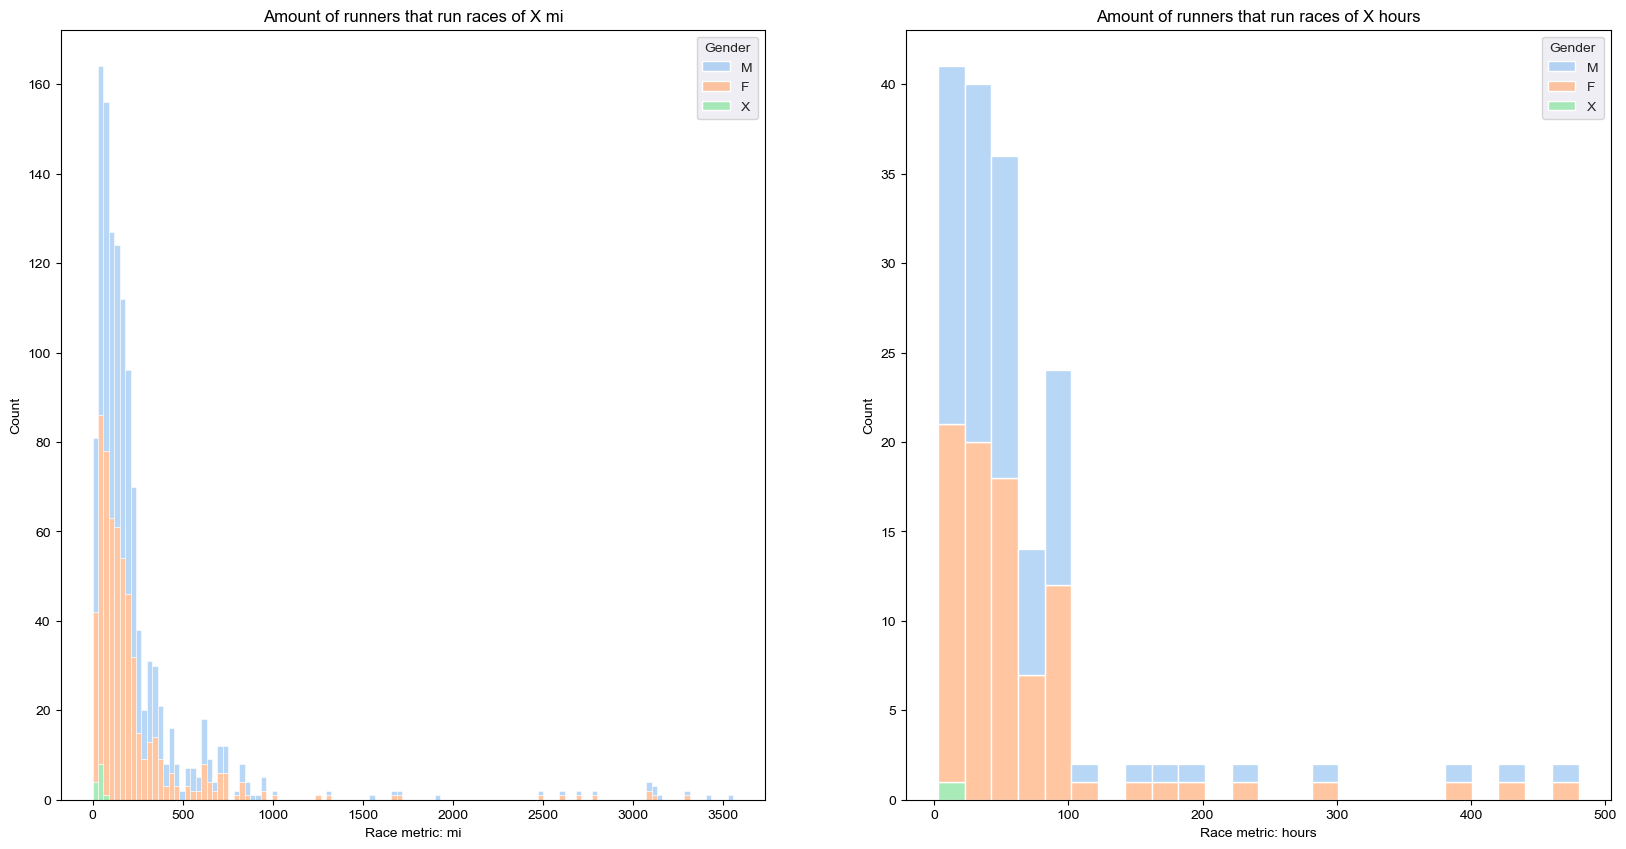

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.set_palette('pastel')
sns.set_style('darkgrid')
for metric, i in [
    ('mi', 0),
    ('hours', 1)
]:
    temp_df = df[
        ['gender', 'distance_or_length', 'race_metric']
    ][
        df['race_metric'] == metric
    ].value_counts().reset_index()

    temp_df.columns = ['Gender', 'Distance', 'Metric', 'Count']

    sns.histplot(
        data=temp_df, 
        x='Distance',
        hue='Gender', 
        multiple='stack',
        ax=ax[i]
    )
    ax[i].set_title(f'Amount of runners that run races of X {metric}')
    ax[i].set_xlabel(f'Race metric: {metric}')
    
fig.savefig(f'{fig_path}count_of_runners_by_distance.jpg')

In [7]:
country_counts = df['athlete_country'].value_counts().reset_index()

def format_hover_text(val):
    if val >= 1e6:
        return f'{val / 1e6:.1f} M'
    elif val >= 1e3:
        return f'{val / 1e3:.1f} K'
    else:
        return f'{val}'
    
country_counts['formatted_vals'] = country_counts['count'].apply(format_hover_text)

fig = px.choropleth(
    country_counts,
    locations='athlete_country',
    color='count',
    hover_name='athlete_country',
    hover_data = {
        'count': False, 
        'formatted_vals': True, 
        'athlete_country': False
    },
    color_continuous_scale=px.colors.sequential.Plasma
)
for trace in fig.data:  
    trace.hovertemplate = '%{customdata[2]}: %{customdata[1]}<extra></extra>'
fig.write_image(f'{fig_path}athletes_per_county.jpg')
fig.show()

In [8]:
athlete_races = df[['athlete_id', 'gender', 'year_of_event', 'birth_year']].copy()
athlete_races['gender'] = athlete_races['gender'].astype('category')
athlete_races['race_age'] = athlete_races['year_of_event'] - athlete_races['birth_year']
race_counts = athlete_races['athlete_id'].value_counts()
athlete_races['race_count'] = athlete_races['athlete_id'].map(race_counts)
athlete_races.drop(columns = ['year_of_event', 'birth_year'], inplace = True)
proper_ages = athlete_races[(athlete_races['race_age'] < 95) & (athlete_races['race_age'] > 14)].copy().reset_index()

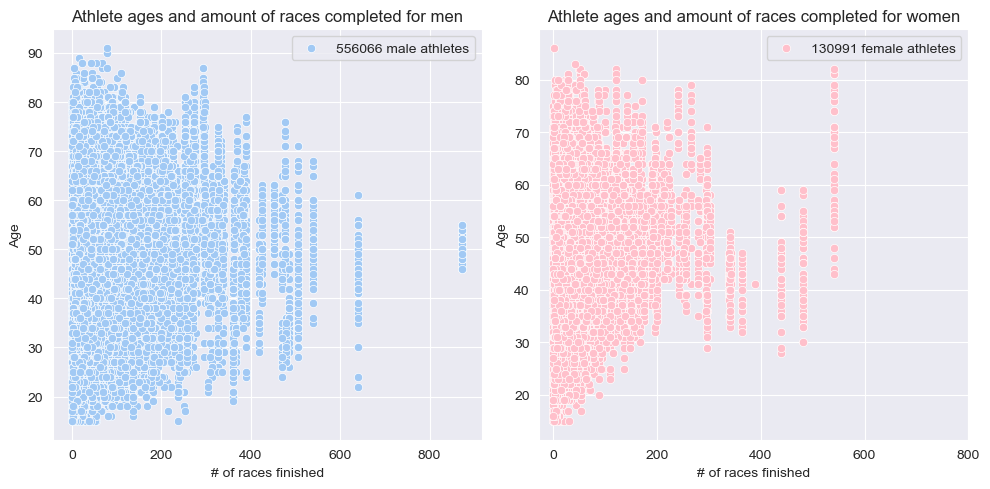

In [9]:
custom_ticks = [0, 200, 400, 600, 800]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

bin_m = proper_ages[proper_ages['gender'] == 'M'].sample(frac = 0.1)
bin_f = proper_ages[proper_ages['gender'] == 'F'].sample(frac = 0.1)

sns.scatterplot(data = bin_m, x = 'race_count', y = 'race_age', ax = ax[0])
ax[0].set_title(f'Athlete ages and amount of races completed for men')
ax[0].set_xlabel('# of races finished')
ax[0].set_ylabel('Age')
ax[0].set_xticks(ticks = custom_ticks, labels = custom_ticks)
ax[0].legend([f'{len(bin_m)} male athletes'])

sns.scatterplot(data = bin_f[bin_f['race_count'] < 1000], x = 'race_count', y = 'race_age', color = 'pink', ax = ax[1])
ax[1].set_title(f'Athlete ages and amount of races completed for women')
ax[1].set_xlabel('# of races finished')
ax[1].set_ylabel('Age')
ax[1].set_xticks(ticks = custom_ticks, labels = custom_ticks)
ax[1].legend([f'{len(bin_f)} female athletes'])
plt.tight_layout()
fig.savefig(f'{fig_path}athlete_ages_and_number_of_races_completed.jpg')

In [10]:
winners_time = df[ 
    (df['fastest_time'] > pd.to_timedelta(0, unit='hours')) & 
    (df['race_metric'] == 'mi')
].sort_values(by='fastest_time', ascending=True).drop_duplicates(subset='event_name')

winners_distance = df[
    (df['distance_or_length'] > 0) &
    (df['race_metric'] == 'hours')
].sort_values(by='distance_or_length', ascending=False).drop_duplicates(subset='event_name')

winners_distance.head()

,year_of_event,event_name,distance_or_length,no_of_finishers,total_distance,athlete_club,athlete_country,birth_year,gender,age_category,average_speed,athlete_id,race_metric,start_date,end_date,fastest_time
2476993,2019,Running Festival Wychwood December 20 Days (RSA),480.00,15,1004.50,Unknown,USA,1938,M,M80,2.093,76752,hours,2019-12-12,2020-01-01,0 days
7121236,1987,"Sri Chinmoy Ultra Trio 1300,1000,700 Mile Race...",432.00,24,912.50,"Ozone Park,NY",USA,1949,M,M35,2112.00,1312053,hours,1987-06-05,1987-06-23,0 days
7167145,1988,Sri Chinmoy Ultra Trio 1300 Mile Race (USA),432.00,2,1886.15,Kleinostheim,GER,1962,M,M23,4366.00,391606,hours,1988-05-20,1988-06-07,0 days
1643202,2017,Ultimate Circuits South Africa 16 Day Challeng...,384.00,5,1001.01,"Cleveland, OH",USA,1948,M,M65,2.607,34750,hours,2017-07-22,2017-08-07,0 days
3769586,1999,12 Days Race Latvia (LAT),288.00,12,216.00,LSC-Ann.,LAT,1939,F,W55,0.75,1097874,hours,1999-09-20,1999-10-02,0 days


In [11]:
winners_time.shape, winners_distance.shape

((21084, 16), (5829, 16))

In [12]:
winner_time_M = winners_time[winners_time['gender'] == 'M']['athlete_id'].value_counts()
winner_time_F = winners_time[winners_time['gender'] == 'F']['athlete_id'].value_counts()

winner_distance_M = winners_distance[winners_distance['gender'] == 'M']['athlete_id'].value_counts()
winner_distance_F = winners_distance[winners_distance['gender'] == 'F']['athlete_id'].value_counts()

winner_time_M

athlete_id
24893      166
36441       66
475391      53
43644       48
4625        47
          ... 
1222152      1
273295       1
1253035      1
1223528      1
255909       1
Name: count, Length: 11840, dtype: int64

In [13]:
merge_men = pd.merge(winner_distance_M, winner_time_M, on = 'athlete_id', how = 'outer', suffixes = ('_1', '_2'))
merge_women = pd.merge(winner_distance_F, winner_time_F, on = 'athlete_id', how = 'outer', suffixes = ('_1', '_2'))

merge_men.fillna(0, inplace = True)
merge_women.fillna(0, inplace = True)

merge_men['total_count'] = merge_men['count_1'] + merge_men['count_2']
merge_women['total_count'] = merge_women['count_1'] + merge_women['count_2']

merge_men.drop(['count_1', 'count_2'], inplace = True, axis = 1)
merge_women.drop(['count_1', 'count_2'], inplace = True, axis = 1)

merge_men.sort_values(by = 'total_count', ascending = False, inplace = True)
merge_women.sort_values(by = 'total_count', ascending = False, inplace = True)

merge_men = merge_men.reset_index()
merge_women = merge_women.reset_index()

merge_men.head()

,athlete_id,total_count
0,24893,166.00
1,36441,66.00
2,475391,53.00
3,43644,49.00
4,4625,47.00


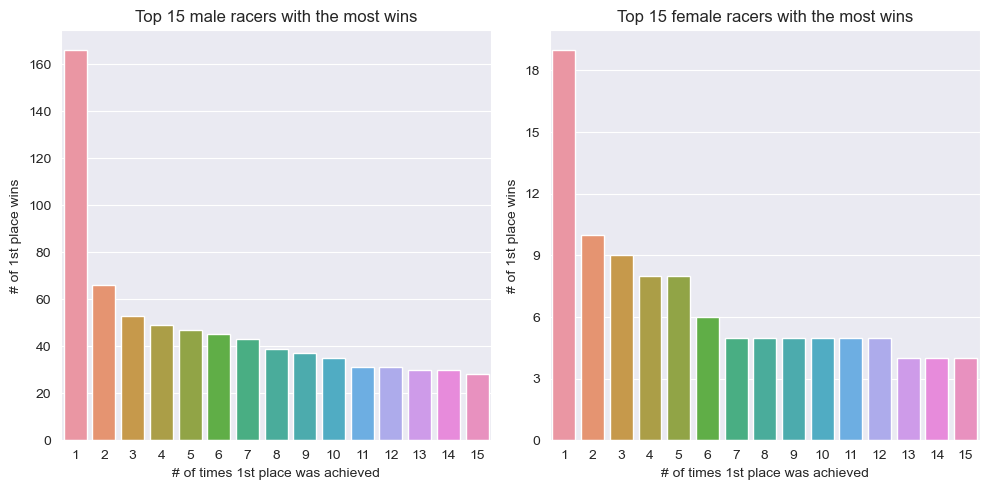

In [14]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
x = np.arange(1, 16, 1)
sns.barplot(data = merge_men.head(15), x = x, y = 'total_count', ax = ax[0])
sns.barplot(data = merge_women.head(15), x = x, y = 'total_count', ax = ax[1])
ax[0].set_title('Top 15 male racers with the most wins')
ax[0].set_xlabel('# of times 1st place was achieved')
ax[0].set_ylabel('# of 1st place wins')
ax[1].set_title('Top 15 female racers with the most wins')
ax[1].set_xlabel('# of times 1st place was achieved')
ax[1].set_ylabel('# of 1st place wins')
ax[1].set_yticks(np.arange(0, 19, 3))
plt.tight_layout()

In [15]:
((df['race_metric'] == 'hours') & (df['total_distance'] == 0)).sum(), ((df['race_metric'] == 'hours') & (df['total_distance'] > 0)).sum()

(81, 526575)

In [16]:
winners_overall_by_time = df[
    (df['race_metric'] == 'hours') &
    (df['distance_or_length'] > 0)
].sort_values(by = 'total_distance', ascending = False).drop_duplicates(subset = 'event_name')
male_victors_hours = (winners_overall_by_time['gender'] == 'M').sum()
female_victors_hours = (winners_overall_by_time['gender'] == 'F').sum()

In [17]:
winners_overall_by_time = df[
    (df['race_metric'] == 'mi') &
    (df['fastest_time'] > pd.to_timedelta(0, unit = 'm'))
].sort_values(by = 'fastest_time', ascending = True).drop_duplicates(subset = 'event_name')
male_victors_time = (winners_overall_by_time['gender'] == 'M').sum()
female_victors_time = (winners_overall_by_time['gender'] == 'F').sum()

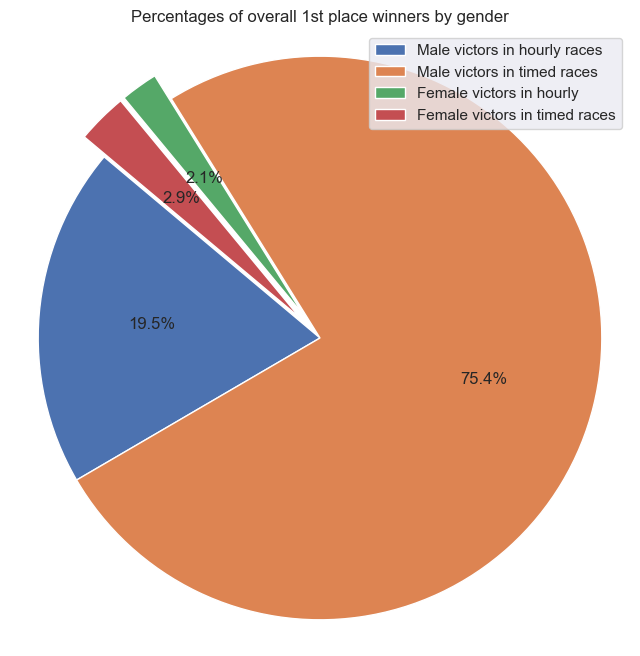

In [18]:
total_victors = male_victors_hours + female_victors_hours + male_victors_time + female_victors_time
labels = ['Male victors in hourly races', 'Male victors in timed races', 'Female victors in hourly ', 'Female victors in timed races']
sizes = [
    (male_victors_hours / total_victors) * 100,
    (male_victors_time / total_victors) * 100,
    (female_victors_hours / total_victors) * 100,
    (female_victors_time / total_victors) * 100
]
explode = [0, 0, 0.1, 0.1]

sns.set()
plt.figure(figsize = (8, 8))
plt.pie(sizes, explode = explode, autopct = '%1.1f%%', startangle = 140)
plt.axis('equal')
plt.title('Percentages of overall 1st place winners by gender')
plt.legend(labels, loc = 'upper right')
plt.savefig(f'{fig_path}overall_victors_by_gender.jpg')
plt.show()